# Data Analysis for FD001

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.nonparametric.smoothers_lowess import lowess
import pymannkendall as mk

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

## Data Preprocessing

In [2]:
train_data_df = pd.read_csv('../../TED/CMAPSSData/train_FD001.txt', sep=' ', header = None)
test_data_df = pd.read_csv('../../TED/CMAPSSData/test_FD001.txt', sep=' ', header = None)
test_labels_at_break_df = pd.read_csv('../../TED/CMAPSSData/RUL_FD001.txt', sep=' ', header = None)

train_data_df.drop(train_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_data_df.drop(test_data_df.columns[[-1, -2]], axis=1, inplace=True)
test_labels_at_break_df.drop(test_labels_at_break_df.columns[[-1]], axis=1, inplace=True)

### Extracting labels and organising the data

In [3]:
column_names = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3']
for i in range(1, 22):
    column_names.append('SensorMeasure' + str(i))
    
train_data_df.columns = column_names
max_cycles_train_df = train_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

train_data_df = pd.merge(train_data_df, max_cycles_train_df, how='inner', on='ID')
train_data_df['RUL'] = train_data_df['MaxCycleID'] - train_data_df['Cycle']
train_data_df.drop(columns=['MaxCycleID'], inplace=True)

test_data_df.columns = column_names
max_cycles_test_df = test_data_df.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})

test_labels_at_break_df.columns = ['RUL']
test_labels_at_break_df['ID'] = max_cycles_test_df['ID']
test_labels_at_break_df['RUL'] = test_labels_at_break_df['RUL'] + max_cycles_test_df['MaxCycleID']

test_data_df = pd.merge(test_data_df, test_labels_at_break_df, how='inner', on='ID')
test_data_df['RUL'] = test_data_df['RUL'] - test_data_df['Cycle']

(array([ 4.,  3., 11.,  7.,  8., 16., 13., 11.,  6.,  4.,  1.,  4.,  4.,
        3.,  1.,  1.,  0.,  1.,  1.,  1.]), array([128. , 139.7, 151.4, 163.1, 174.8, 186.5, 198.2, 209.9, 221.6,
       233.3, 245. , 256.7, 268.4, 280.1, 291.8, 303.5, 315.2, 326.9,
       338.6, 350.3, 362. ]), <BarContainer object of 20 artists>)


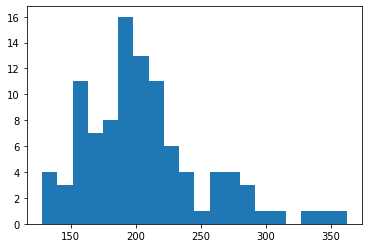

In [4]:
histogram = plt.hist(train_data_df.groupby(['ID']).last()['Cycle'], bins=20)
print(histogram)

In [5]:
train_labels_df = train_data_df['RUL']
test_labels_df = test_data_df['RUL']
train_labels_at_break_df = train_data_df.groupby('ID').last().reset_index()['RUL']

### Divide by engine

In [6]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

### Graphs: Data before analysed

In [7]:
sensor_names = []
for i in range(3):
    sensor_names.append('OpSet' + str(i+1))
for i in range(21):
    sensor_names.append('SensorMeasure' + str(i+1))

In [8]:
def divide_by_engine(df_groupby):

    groupby_arr = []
    for i in range(len(df_groupby)):
        groupby_arr.append(df_groupby.get_group(i+1))

    for i in range(len(df_groupby)):
        groupby_arr[i] = groupby_arr[i].to_numpy()

    return groupby_arr

In [9]:
def plot_by_engine(train_gb, rows, names, filename):

    train_groupby_arr = divide_by_engine(train_gb)

    fig, axs = plt.subplots(rows, 4)
    flat_axs = axs.flatten()
    for sensor in range(len(names)):
        flat_axs[sensor].set_title(names[sensor])
        for engine in range(len(train_groupby_arr)):
            flat_axs[sensor].plot(train_groupby_arr[engine][:, 1], train_groupby_arr[engine][:, sensor + 2])

    plt.setp(axs[-1, :], xlabel='Cycles')
    plt.setp(axs[:, 0], ylabel='Sensor readings')
    fig.set_size_inches(20, 30) 
    plt.savefig(filename)
    plt.show()

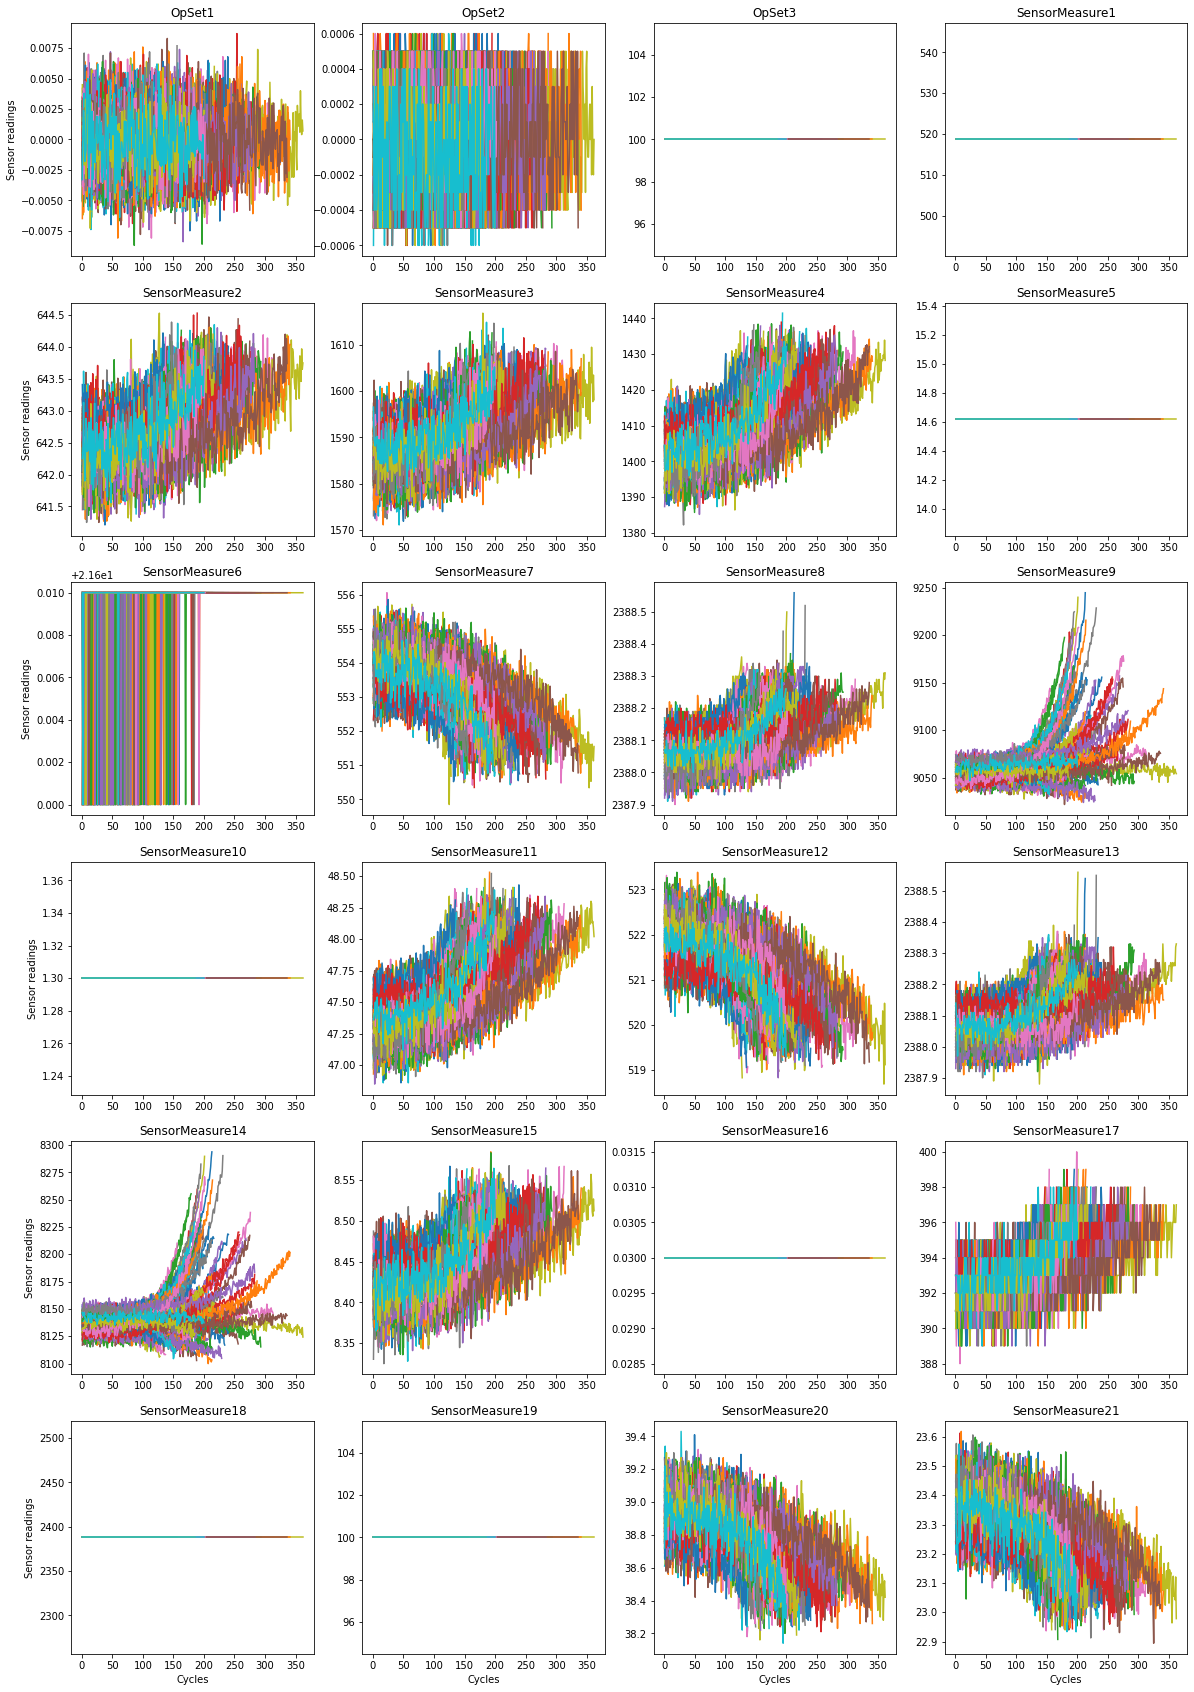

In [10]:
plot_by_engine(train_groupby, 6, sensor_names, 'fd001-sensors_unprocessed.jpg')

### Taking away all non-important sensors

In [11]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 6, 10, 16, 18, 19]:
    sensors_used.append("SensorMeasure" + str(i))

In [12]:
train_data_df = train_data_df[sensors_used]
train_grouppby = train_data_df.groupby(['ID'], sort=False)
test_groupby = test_data_df.groupby(['ID'], sort=False)

In [13]:
train_data_df

ID  Cycle  SensorMeasure1  SensorMeasure2  SensorMeasure3  \
0        1      1          518.67          641.82         1589.70   
1        1      2          518.67          642.15         1591.82   
2        1      3          518.67          642.35         1587.99   
3        1      4          518.67          642.35         1582.79   
4        1      5          518.67          642.37         1582.85   
...    ...    ...             ...             ...             ...   
20626  100    196          518.67          643.49         1597.98   
20627  100    197          518.67          643.54         1604.50   
20628  100    198          518.67          643.42         1602.46   
20629  100    199          518.67          643.23         1605.26   
20630  100    200          518.67          643.85         1600.38   

       SensorMeasure4  SensorMeasure5  SensorMeasure6  SensorMeasure7  \
0             1400.60           14.62           21.61          554.36   
1             1403.14           14.62           21.61          553.75   
2             1404.20           14.62           21.61          554.26   
3             1401.87           14.62           21.61          554.45   
4             1406.22           14.62           21.61          554.00   
...               ...             ...             ...             ...   
20626         1428.63           14.62           21.61          551.43   
20627         1433.58           14.62           21.61          550.86   
20628         1428.18           14.62           21.61          550.94   
20629         1426.53           14.62           21.61          550.68   
20630         1432.14           14.62           21.61          550.79   

       SensorMeasure8  ...  SensorMeasure12  SensorMeasure13  SensorMeasure14  \
0             2388.06  ...           521.66          2388.02          8138.62   
1             2388.04  ...           522.28          2388.07          8131.49   
2             2388.08  ...           522.42          2388.03          8133.23   
3             2388.11  ...           522.86          2388.08          8133.83   
4             2388.06  ...           522.19          2388.04          8133.80   
...               ...  ...              ...              ...              ...   
20626         2388.19  ...           519.49          2388.26          8137.60   
20627         2388.23  ...           519.68          2388.22          8136.50   
20628         2388.24  ...           520.01          2388.24          8141.05   
20629         2388.25  ...           519.67          2388.23          8139.29   
20630         2388.26  ...           519.30          2388.26          8137.33   

       SensorMeasure15  SensorMeasure16  SensorMeasure17  SensorMeasure18  \
0               8.4195             0.03              392             2388   
1               8.4318             0.03              392             2388   
2               8.4178             0.03              390             2388   
3               8.3682             0.03              392             2388   
4               8.4294             0.03              393             2388   
...                ...              ...              ...              ...   
20626           8.4956             0.03              397             2388   
20627           8.5139             0.03              395             2388   
20628           8.5646             0.03              398             2388   
20629           8.5389             0.03              395             2388   
20630           8.5036             0.03              396             2388   

       SensorMeasure19  SensorMeasure20  SensorMeasure21  
0                100.0            39.06          23.4190  
1                100.0            39.00          23.4236  
2                100.0            38.95          23.3442  
3                100.0            38.88          23.3739  
4                100.0            38.90          23.4044  
...                ...              ...           

### Principal Component Analysis

In [14]:
train_data_df.shape
ms_used = sensors_used[2:]

In [15]:
sc = MinMaxScaler()
scaled_values = sc.fit_transform(train_data_df.values[:, 2:])

pca = PCA(n_components = 0.99)
pca_values = pca.fit_transform(scaled_values)

Number of components: 13


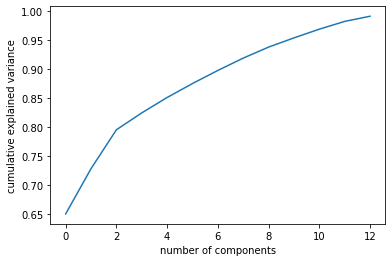

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
print("Number of components: " + str(pca.n_components_))

In [17]:
pd.DataFrame(pca.components_, columns = ms_used)

SensorMeasure1  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0             -0.0        0.293667        0.245278        0.325724   
1              0.0        0.041032        0.127250        0.021994   
2             -0.0        0.016049       -0.004039        0.015067   
3             -0.0       -0.914529        0.340064        0.061381   
4             -0.0       -0.237183       -0.877375        0.063059   
5              0.0        0.058896        0.076579       -0.101565   
6              0.0        0.006930       -0.018315        0.048215   
7              0.0       -0.020593       -0.033994       -0.001151   
8              0.0       -0.103239       -0.162773        0.500356   
9              0.0        0.018122        0.042129        0.722852   
10            -0.0       -0.030719       -0.014211       -0.253797   
11             0.0        0.033245        0.012165        0.135356   
12             0.0       -0.046985       -0.047123       -0.130972   

    SensorMeasure5  SensorMeasure6  SensorMeasure7  SensorMeasure8  \
0     1.084202e-19        0.061410       -0.301930        0.213292   
1     1.110223e-16       -0.257620        0.075013       -0.249344   
2     6.938894e-18       -0.964037       -0.034883        0.081371   
3     1.110223e-16       -0.003531       -0.074785        0.024393   
4     2.775558e-17       -0.015453       -0.043279       -0.004386   
5     2.359224e-16        0.011645        0.059935       -0.017828   
6     1.040834e-16       -0.000048        0.027480       -0.027744   
7    -2.081668e-17       -0.006729        0.018857        0.001437   
8    -1.370432e-16       -0.000552       -0.247122        0.011882   
9     4.510281e-17        0.003620        0.606744        0.019242   
10    2.220446e-16        0.002515        0.631825       -0.027466   
11    1.110223e-16        0.004599       -0.214961       -0.074400   
12    1.387779e-16       -0.001638        0.123222        0.659552   

    SensorMeasure9  SensorMeasure10  ...  SensorMeasure12  SensorMeasure13  \
0         0.072694    -1.009742e-28  ...        -0.341451         0.209422   
1         0.606859     0.000000e+00  ...         0.100500        -0.247477   
2        -0.159850    -0.000000e+00  ...        -0.050511         0.074930   
3        -0.001132    -5.551115e-17  ...        -0.053849         0.022296   
4         0.064108    -0.000000e+00  ...        -0.028910        -0.003812   
5        -0.015931    -0.000000e+00  ...         0.044820        -0.012081   
6         0.044429    -2.671474e-16  ...        -0.000918        -0.029494   
7         0.017271    -2.220446e-16  ...        -0.016881        -0.006334   
8         0.122687    -1.110223e-16  ...        -0.307276         0.013259   
9        -0.081020     1.457168e-16  ...         0.232648         0.018324   
10        0.026022    -2.081668e-17  ...        -0.707110        -0.003710   
11       -0.003365    -3.330669e-16  ...        -0.453895        -0.058743   
12        0.259304     3.747003e-16  ...         0.098002         0.571425   

    SensorMeasure14  SensorMeasure15  SensorMeasure16  SensorMeasure17  \
0          0.044691         0.294237     6.162976e-33         0.244553   
1          0.624043         0.038118     0.000000e+00         0.114386   
2         -0.165842        -0.002243    -2.584939e-26        -0.018127   
3         -0.004234         0.076913    -0.000000e+00         0.061604   
4          0.060188         0.142829    -0.000000e+00         0.180297   
5         -0.017813        -0.278218    -0.000000e+00        -0.225434   
6          0.045918         0.106449    -5.551115e-17        -0.814761   
7          0.016454         0.789760     0.000000e+00        -0.270795   
8          0.118157        -0.403301     2.775558e-17        -0.299218   
9         -0.081295         0.051451     1.110223e-16         0.082019   
10         0.022905        -0.026732     2.775558e-17         0.013025   
11        -0.000907         0.036668     6.938894e-18        

In [18]:
n_pcs = pca.n_components_
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ms_used
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

print(most_important_names)

['SensorMeasure11', 'SensorMeasure14', 'SensorMeasure6', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure21', 'SensorMeasure17', 'SensorMeasure15', 'SensorMeasure4', 'SensorMeasure4', 'SensorMeasure12', 'SensorMeasure11', 'SensorMeasure8']


In [19]:
fig = px.scatter_3d(pca_values, x=0, y=1, z=2, color=train_data_df['ID'])
fig.show()
fig.write_html("fd001-PCA-3d_plot.html")

### Feature Selection using Mann-Kendall method

<function matplotlib.pyplot.show(close=None, block=None)>

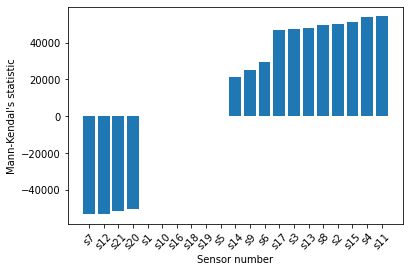

In [20]:
# PyMannKendall test: Code by Zhan Liang, Chan - https://github.com/cchanzl/survival-analysis-nasa/blob/main/nasa_eda.ipynb
avg_cycle = []
for i in range(1, 101):
    df_engine = train_data_df[train_data_df['ID'] == i]
    max_cycle = df_engine.loc[df_engine['Cycle'].idxmax()]
    avg_cycle.append(max_cycle["Cycle"].astype(int))

no_columns = 21
up_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
lo_sensor_values = np.empty([max(avg_cycle), no_columns]) # 26 sensors with a max cycle of 362
for col in range(0, no_columns):
    sensor = 'SensorMeasure'
    sensor = sensor + str(col+1)
    for row in range(0, max(avg_cycle)):
        df_train_sens = train_data_df[train_data_df['Cycle'] == row+1]
        
        # find max and min value of a sensor for each cycle
        max_value = df_train_sens.loc[df_train_sens[sensor].idxmax()]
        min_value = df_train_sens.loc[df_train_sens[sensor].idxmin()]
        
        # store max and min value
        up_sensor_values[row, col] = max_value[sensor]
        lo_sensor_values[row, col] = min_value[sensor]
mean_trend = (up_sensor_values + lo_sensor_values)/2

mono = []
def MannKendall(sensor_number, mean_trend, p_value=False):
    sensor_number -= 1
    trend, h, p, z, Tau, s, var_s, slope, intercept = mk.original_test([row[sensor_number] for row in mean_trend], alpha=0.05)
    if p_value:
        print("{:e}".format(var_s))
    return s

# make x label for graphing
sensor_header = []
for i in range(0, 21):
    name = "s"
    name = name + str(i+1)
    sensor_header.append(name)

# retrieve y axis reading
for i in range(1, no_columns+1):
    mono.append(MannKendall(i, mean_trend))

y,x = zip(*sorted(zip(mono,sensor_header)))
plt.bar(x, y)
plt.xlabel("Sensor number")
plt.ylabel("Mann-Kendal's statistic")
plt.xticks(rotation=45)
plt.show

According to the PyMannKendall test, the most useful sensors would be 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20, 21. I will follow Zhan's decision on feature selection.

In [21]:
train_labels_df.to_csv('./fd001-training_labels.csv', sep=' ', columns=['RUL'], index=False)
test_labels_df.to_csv('./fd001-testing_labels.csv', sep=' ', columns=['RUL'], index=False)
train_labels_at_break_df.to_csv('./fd001-testing_labels_at_break.csv', sep=' ', columns=['RUL'], index=False)

In [22]:
sensors_used = []
sensors_used.append('ID')
sensors_used.append('Cycle')
for i in range(1, 22):
    # if i not in [1, 5, 16, 18, 19]:
    if i not in [1, 5, 6, 9, 10, 14, 16, 18, 19]:
        sensors_used.append("SensorMeasure" + str(i))
ms_used = sensors_used[2:]

### Scaling and Normalising Data

In [23]:
train_data_df = train_data_df[sensors_used]
test_data_df = test_data_df[sensors_used]

In [24]:
train_data_df.to_csv('./fd001-raw_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df.to_csv('./fd001-raw_test.csv', sep=' ', columns=train_data_df.columns, index=False)

In [25]:
sc = MinMaxScaler()
for sensor in ms_used:
    train_data_df.loc[:,sensor] = sc.fit_transform(train_data_df[sensor].values.reshape(-1, 1))
    test_data_df.loc[:,sensor] = sc.fit_transform(test_data_df[sensor].values.reshape(-1, 1))


# sc = MinMaxScaler()
# train_data_df[ms_used] = pd.DataFrame(sc.fit_transform(train_data_df[ms_used]), columns = ms_used)
# test_data_df[ms_used] = pd.DataFrame(sc.fit_transform(test_data_df[ms_used]), columns = ms_used)


/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_14883/1262172320.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_14883/1262172320.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/4z/dx20wtl948x13fj468s2l3280000gn/T/ipykernel_14883/1262172320.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [26]:
train_data_df

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0        1      1        0.183735        0.406802        0.309757   
1        1      2        0.283133        0.453019        0.352633   
2        1      3        0.343373        0.369523        0.370527   
3        1      4        0.343373        0.256159        0.331195   
4        1      5        0.349398        0.257467        0.404625   
...    ...    ...             ...             ...             ...   
20626  100    196        0.686747        0.587312        0.782917   
20627  100    197        0.701807        0.729453        0.866475   
20628  100    198        0.665663        0.684979        0.775321   
20629  100    199        0.608434        0.746021        0.747468   
20630  100    200        0.795181        0.639634        0.842167   

       SensorMeasure7  SensorMeasure8  SensorMeasure11  SensorMeasure12  \
0            0.726248        0.242424         0.369048         0.633262   
1            0.628019        0.212121         0.380952         0.765458   
2            0.710145        0.272727         0.250000         0.795309   
3            0.740741        0.318182         0.166667         0.889126   
4            0.668277        0.242424         0.255952         0.746269   
...               ...             ...              ...              ...   
20626        0.254428        0.439394         0.726190         0.170576   
20627        0.162641        0.500000         0.708333         0.211087   
20628        0.175523        0.515152         0.738095         0.281450   
20629        0.133655        0.530303         0.916667         0.208955   
20630        0.151369        0.545455         0.803571         0.130064   

       SensorMeasure13  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0             0.205882         0.363986         0.333333         0.713178   
1             0.279412         0.411312         0.333333         0.666667   
2             0.220588         0.357445         0.166667         0.627907   
3             0.294118         0.166603         0.333333         0.573643   
4             0.235294         0.402078         0.416667         0.589147   
...                ...              ...              ...              ...   
20626         0.558824         0.656791         0.750000         0.271318   
20627         0.500000         0.727203         0.583333         0.124031   
20628         0.529412         0.922278         0.833333         0.232558   
20629         0.514706         0.823394         0.583333         0.116279   
20630         0.558824         0.687572         0.666667         0.178295   

       SensorMeasure21  
0             0.724662  
1             0.731014  
2             0.621375  
3             0.662386  
4             0.704502  
...                ...  
20626         0.109500  
20627         0.366197  
20628         0.053991  
20629         0.234466  
20630         0.218172  

[20631 rows x 14 columns]

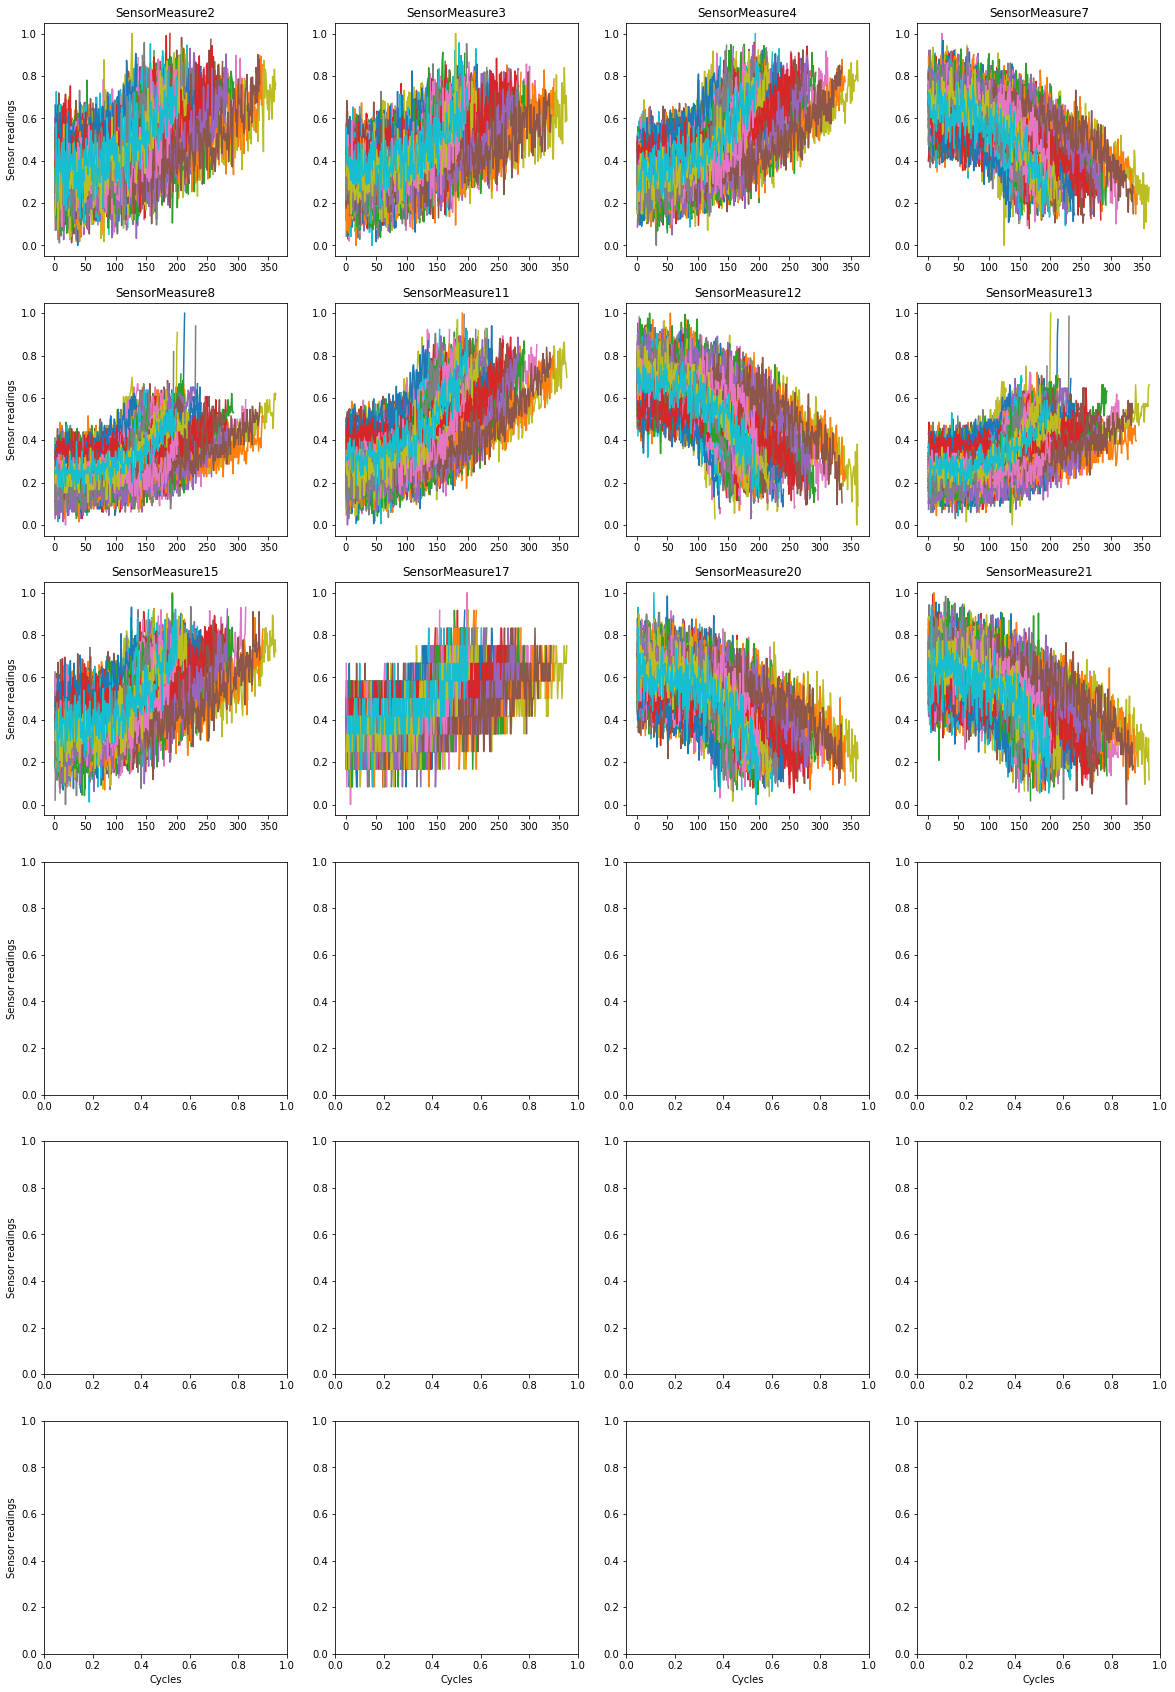

In [27]:
train_groupby = train_data_df.groupby(['ID'], sort=False)
plot_by_engine(train_groupby, 6, ms_used, 'fd001-sensors_scaled.jpg')

In [28]:
train_data_df.to_csv('./fd001-scaled_train.csv', sep=' ', columns=train_data_df.columns, index=False)
test_data_df[train_data_df.columns].to_csv('./fd001-scaled_test.csv', sep=' ', columns=train_data_df.columns, index=False)

### Smoothing curves

In [29]:
train_groupby = train_groupby[['ID', 'Cycle'] + ms_used]
test_groupby = test_groupby[['ID', 'Cycle'] + ms_used]
train_groupby.get_group(1)

ID  Cycle  SensorMeasure2  SensorMeasure3  SensorMeasure4  \
0     1      1        0.183735        0.406802        0.309757   
1     1      2        0.283133        0.453019        0.352633   
2     1      3        0.343373        0.369523        0.370527   
3     1      4        0.343373        0.256159        0.331195   
4     1      5        0.349398        0.257467        0.404625   
..   ..    ...             ...             ...             ...   
187   1    188        0.765060        0.683235        0.684166   
188   1    189        0.894578        0.547853        0.772451   
189   1    190        0.731928        0.614345        0.737677   
190   1    191        0.641566        0.682799        0.734639   
191   1    192        0.701807        0.662089        0.758778   

     SensorMeasure7  SensorMeasure8  SensorMeasure11  SensorMeasure12  \
0          0.726248        0.242424         0.369048         0.633262   
1          0.628019        0.212121         0.380952         0.765458   
2          0.710145        0.272727         0.250000         0.795309   
3          0.740741        0.318182         0.166667         0.889126   
4          0.668277        0.242424         0.255952         0.746269   
..              ...             ...              ...              ...   
187        0.336554        0.621212         0.684524         0.234542   
188        0.136876        0.560606         0.732143         0.189765   
189        0.231884        0.590909         0.880952         0.287846   
190        0.172303        0.575758         0.773810         0.187633   
191        0.225443        0.636364         0.833333         0.296375   

     SensorMeasure13  SensorMeasure15  SensorMeasure17  SensorMeasure20  \
0           0.205882         0.363986         0.333333         0.713178   
1           0.279412         0.411312         0.333333         0.666667   
2           0.220588         0.357445         0.166667         0.627907   
3           0.294118         0.166603         0.333333         0.573643   
4           0.235294         0.402078         0.416667         0.589147   
..               ...              ...              ...              ...   
187         0.514706         0.753367         0.666667         0.286822   
188         0.661765         0.744132         0.583333         0.263566   
189         0.691176         0.759523         0.833333         0.271318   
190         0.617647         0.740669         0.500000         0.240310   
191         0.647059         0.717199         0.666667         0.263566   

     SensorMeasure21  
0           0.724662  
1           0.731014  
2           0.621375  
3           0.662386  
4           0.704502  
..               ...  
187         0.089202  
188         0.301712  
189         0.239299  
190         0.324910  
191         0.097625  

[192 rows x 14 columns]

In [30]:
smoothing_columns = ['ID', 'Cycle'] + ms_used
train_groupby_arr = []
for i in range(len(train_groupby)):
    df = train_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.75)[:, 1], index=df.index, columns=[sn])
    train_groupby_arr.append(lowess_df)

tr_joined_lowess_df = train_groupby_arr[0]
for i in range(1, len(train_groupby_arr)):
    tr_joined_lowess_df = pd.concat([tr_joined_lowess_df, train_groupby_arr[i]])

test_groupby_arr = []
for i in range(len(test_groupby)):
    df = test_groupby.get_group(i+1).copy()
    lowess_df = df.copy()
    for sensor in range(2, len(smoothing_columns)):
        sn = smoothing_columns[sensor]
        lowess_df[sn] = pd.DataFrame(lowess(df[sn], np.arange(len(df[sn])), frac=0.75)[:, 1], index=df.index, columns=[sn])
    test_groupby_arr.append(lowess_df)

test_joined_lowess_df = test_groupby_arr[0]
for i in range(1, len(test_groupby_arr)):
    test_joined_lowess_df = pd.concat([test_joined_lowess_df, test_groupby_arr[i]])

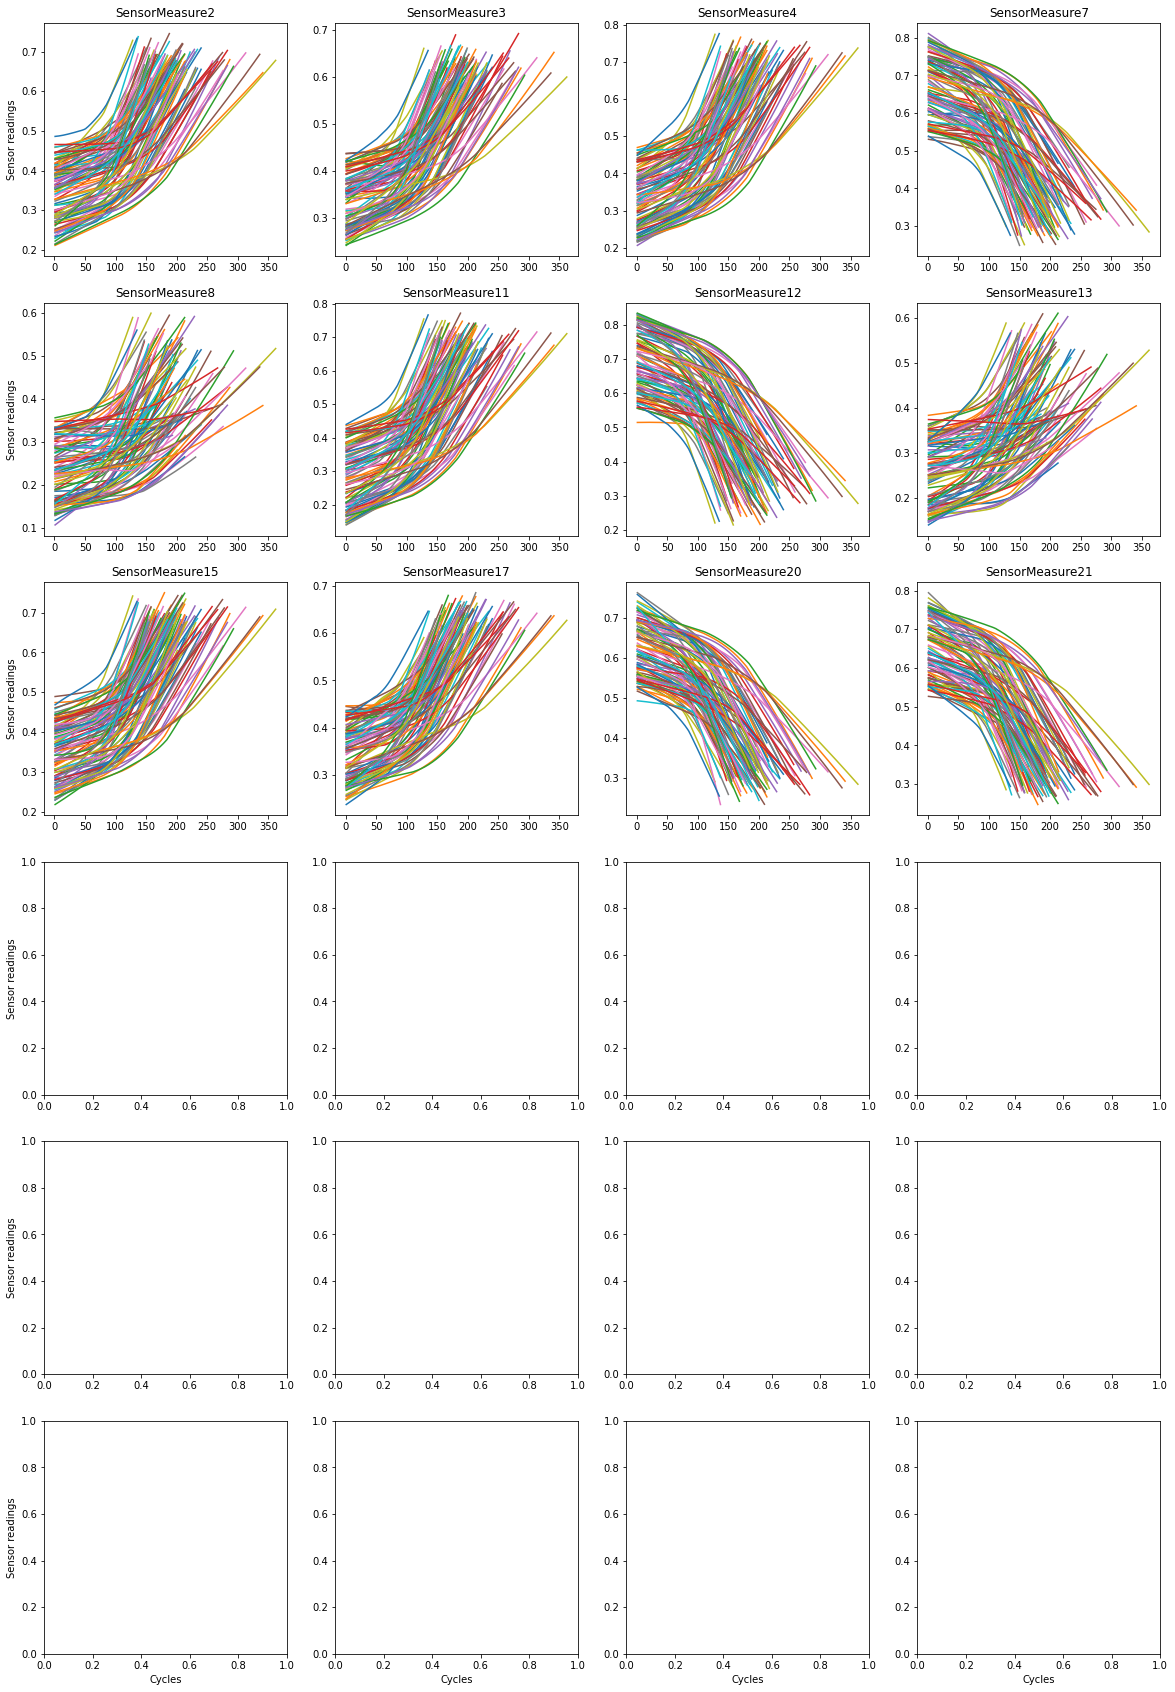

In [31]:
tr_joined_lowess_groupby = tr_joined_lowess_df.groupby(['ID'], sort = False)
plot_by_engine(tr_joined_lowess_groupby, 6, ms_used, 'fd001-sensors_smoothed.jpg')

In [32]:
tr_joined_lowess_df.to_csv('./fd001-smoothed_train.csv', sep=' ', columns=tr_joined_lowess_df.columns, index=False)
test_joined_lowess_df.to_csv('./fd001-smoothed_test.csv', sep=' ', columns=test_joined_lowess_df.columns, index=False)